In [1]:
import numpy as np
import pickle
import csv
import torch
from numpy.array_api import int32
from torch.linalg import inv, eig, pinv
from matplotlib import pyplot as plt
from tools import whiten, adap_whitening, adap_whitening_2
from sklearn import svm, metrics
from sklearn.decomposition import PCA
from datetime import datetime
import sklearn
import pickle
from scipy.ndimage import gaussian_filter1d
from tools import load, split, estimate_derivative, plot_two_intervals

/tmp/ipykernel_1218177/4138892169.py:5: UserWarning: The numpy.array_api submodule is still experimental. See NEP 47.
  from numpy.array_api import int32


In [2]:
from matplotlib import font_manager as fm, rcParams

path = r"/home/p308270/.local/share/fonts/Helvetica.ttf"  # or .otf
fm.fontManager.addfont(path)
rcParams["font.family"] = fm.FontProperties(fname=path).get_name()

In [3]:
def find_blocks(labels, max_len=20, ignore=0):
    """
    Split a 1D array of integer labels into contiguous blocks.
    - Blocks with label == `ignore` (default 0) are skipped.
    - Long runs are split into chunks of at most `max_len`.
    Returns: list of (start_idx, end_idx, label) with end_idx exclusive.
    """
    labels = np.asarray(labels)
    n = len(labels)
    if n == 0:
        return []

    blocks = []
    start = 0
    prev = labels[0]

    # walk + flush on change (and once at the end)
    for i in range(1, n + 1):
        cur = labels[i] if i < n else None
        if cur != prev:
            if prev != ignore:
                run_start, run_end, lab = start, i, int(prev)
                # chunk the run to respect max_len
                s = run_start
                while s < run_end:
                    e = min(s + max_len, run_end)
                    blocks.append((s, e, lab))
                    s = e
            start = i
            prev = cur

    return blocks

In [4]:
n_hd = 10000
n_out = 3
k = 50
n_pot = 10
n_train = 225
w_teacher = 1.
t_training_delay = 5.
filename = '1_600_20'

grid_uniformW = [False]
grid_normalized = [False]
grid_whitened = [False]
grid_k = [10, 15, 20, 25]
grid_n_pot = [n for n in range(2, 20, 2)]
grid_t_training_delay = [n for n in range(0, 20, 5)]
grid_n_fold = 5


sensor_data, sequence, times_sec, sequence_sec = load(filename, reduced=True)
d_sensor_data = np.apply_along_axis(estimate_derivative, axis=0, arr=sensor_data)
sensor_data = np.hstack((sensor_data, d_sensor_data))

# baseline = np.mean(sensor_data[:300], axis=0)  # Add baseline substraction
# sensor_data = (sensor_data - baseline)

In [ ]:
params = {'uniformW': [], 'normalized': [], 'whitened': [], 'k': [], 'n_pot': [], 't_training_delay': [], 'n_fold': []}
results = {'train_acc': [], 'test_acc': []}
for uniformW in grid_uniformW:
    for normalized in grid_normalized:
        for whitened in grid_whitened:
            for k in grid_k:
                for n_pot in grid_n_pot:
                    for t_training_delay in grid_t_training_delay:
                        for n_fold in range(grid_n_fold):
                            for key in params.keys():
                                params[key].append(locals()[key])

                            if normalized:
                                sensor_data_norm = (sensor_data - np.mean(sensor_data, axis=0))/ np.std(sensor_data, axis=0)
                            else:
                                sensor_data_norm = sensor_data

                            # x_dense, _, _, _ = adap_whitening_2(sensor_data_norm)
                            if whitened:
                                x_dense = adap_whitening_2(sensor_data_norm)
                            else:
                                x_dense = sensor_data_norm

                            n_dense = x_dense.shape[1]

                            labels = np.zeros_like(times_sec)
                            for i, t in enumerate(sequence_sec[:n_train]):
                                try:
                                    flag = (times_sec > sequence_sec[i] + t_training_delay) & (times_sec < sequence_sec[i+1])
                                except IndexError:
                                    flag = (times_sec > sequence_sec[i] + t_training_delay)
                                labels[flag] = int(sequence[i][1])

                            idx_last_flag = np.where(labels != 0)[0][-1]

                            if uniformW:
                                W_hd = np.random.uniform(high=1/np.sqrt(n_dense), size=(n_hd, n_dense))  #Test random sparse weights
                            else:
                                W_hd = np.random.binomial(n=1, p=0.05, size=(n_hd, n_dense))  #Test random sparse weights
                            x_hd = x_dense @ W_hd.T
                            z_hd = np.where(np.argsort(x_hd)<k, 1., 0)
                            W_out = np.zeros((n_out, n_hd))
                            W = np.zeros((n_out, n_hd))

                            z_out_train = np.zeros((z_hd.shape[0],  n_out))
                            for i, row in enumerate(z_hd[:idx_last_flag]):
                                teacher = np.zeros((n_out,))
                                if labels[i] != 0:
                                    teacher[int(labels[i]-1)] = w_teacher
                                out = row @ W_out.T + teacher
                                z_out_train[i] = out
                                dW = (1./n_pot)*(np.atleast_2d(out).T @ np.atleast_2d(row))
                                W += dW
                                W_out = np.where(W>=1., 1./k, 0.)
                                # if i%100 == 0:
                                #     print(np.sum(W_out, axis=1))

                            z_out = np.zeros((z_hd.shape[0],  n_out))
                            for i, row in enumerate(z_hd):
                                out = row @ W_out.T
                                z_out[i] = out

                            z_wta = np.where(np.argsort(z_out, axis=1)<1, 1., 0)

                            z_pred = np.zeros_like(sequence_sec)
                            z_true = np.zeros_like(sequence_sec)
                            for i, t in enumerate(sequence_sec):
                                try:
                                    flag = (times_sec > sequence_sec[i] + t_training_delay) & (times_sec < sequence_sec[i+1])
                                except IndexError:
                                    flag = (times_sec > sequence_sec[i] + t_training_delay)
                                z_pred[i] = np.argsort(np.sum(z_out[flag], axis=0))[-1] + 1
                                z_true[i] = sequence[i][1]

                            train_acc = sklearn.metrics.accuracy_score(z_true[:n_train], z_pred[:n_train])
                            test_acc = sklearn.metrics.accuracy_score(z_true[n_train:], z_pred[n_train:])
                            results['train_acc'].append(train_acc)
                            results['test_acc'].append(test_acc)
                            results['y_pred'].append(z_pred.copy())
                            results['y_true'].append(z_true.copy())

                            print(f'UniformW: {uniformW}, Normalized: {normalized}, Whitened: {whitened}, k: {k}, n_pot: {n_pot}, t_training_delay: {t_training_delay}, n_fold: {n_fold}')
                            print(f'Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}')

for key in params.keys():
    params[key] = np.array(params[key])
for k in ['train_acc', 'test_acc']:
    results[k] = np.array(results[k])
# keep y_pred / y_true as lists-of-arrays (ragged OK) or cast to object arrays:
results['y_pred'] = np.array(results['y_pred'], dtype=object)
results['y_true'] = np.array(results['y_true'], dtype=object)

data = {'params': params, 'results': results}

with open('data/gridsearch_full.pkl', 'wb') as f:
    pickle.dump(data, f)

UniformW: False, Normalized: False, Whitened: False, k: 10, n_pot: 2, t_training_delay: 0, n_fold: 0
Train accuracy: 1.0000, Test accuracy: 0.8960
UniformW: False, Normalized: False, Whitened: False, k: 10, n_pot: 2, t_training_delay: 0, n_fold: 1
Train accuracy: 0.9956, Test accuracy: 0.8027
UniformW: False, Normalized: False, Whitened: False, k: 10, n_pot: 2, t_training_delay: 0, n_fold: 2
Train accuracy: 1.0000, Test accuracy: 0.9467
UniformW: False, Normalized: False, Whitened: False, k: 10, n_pot: 2, t_training_delay: 0, n_fold: 3
Train accuracy: 1.0000, Test accuracy: 0.8400
UniformW: False, Normalized: False, Whitened: False, k: 10, n_pot: 2, t_training_delay: 0, n_fold: 4
Train accuracy: 1.0000, Test accuracy: 0.8933
UniformW: False, Normalized: False, Whitened: False, k: 10, n_pot: 2, t_training_delay: 5, n_fold: 0
Train accuracy: 1.0000, Test accuracy: 0.8000
UniformW: False, Normalized: False, Whitened: False, k: 10, n_pot: 2, t_training_delay: 5, n_fold: 1
Train accuracy: 0

Best params → k=10, N_pot=6, t_delay=5 s
Highest mean test accuracy: 0.9483 ± 0.0310 (n=5)
Highest single-fold test accuracy at those params: 0.9867, n_fold=0


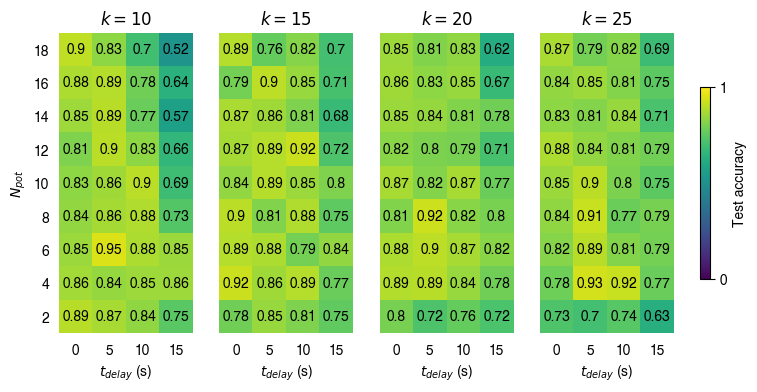

In [5]:
grid_k = [10, 15, 20, 25]
grid_n_pot = [n for n in range(2, 20, 2)]
grid_t_training_delay = [n for n in range(0, 20, 5)]
grid_n_fold = 5

with open('data/gridsearch_full.pkl', 'rb') as f:
    data = pickle.load(f)
params = data['params']
results = data['results']

for key in params.keys():
    params[key] = np.array(params[key])
for key in results.keys():
    results[key] = np.array(results[key])

ims = np.zeros((len(grid_k), len(grid_n_pot), len(grid_t_training_delay)))  # mean test acc
stds = np.zeros_like(ims)   # std of test acc
maxs = np.zeros_like(ims)   # max single-fold test acc

for i, k in enumerate(grid_k):
    for j, n_pot in enumerate(grid_n_pot):
        for l, t_training_delay in enumerate(grid_t_training_delay):

            flags = np.stack((params['k']==k,
                              params['n_pot']==n_pot,
                              params['t_training_delay']==t_training_delay), axis=1).all(axis=1)

            # collect values for this combo
            vals_train = np.asarray(results['train_acc'][flags], dtype=float)
            vals_test  = np.asarray(results['test_acc'][flags],  dtype=float)

            # store summary stats for plotting/selection
            ims[i, j, l]  = np.nanmean(vals_test)
            stds[i, j, l] = np.nanstd(vals_test)
            maxs[i, j, l] = np.nanmax(vals_test)

# === NEW: print best combo and its stats ===
best_idx = np.unravel_index(np.nanargmax(ims), ims.shape)
best_k   = grid_k[best_idx[0]]
best_np  = grid_n_pot[best_idx[1]]
best_td  = grid_t_training_delay[best_idx[2]]

best_flags = np.stack((params['k']==best_k,
                       params['n_pot']==best_np,
                       params['t_training_delay']==best_td), axis=1).all(axis=1)
best_vals  = np.asarray(results['test_acc'][best_flags], dtype=float)
# NEW: identify which n_fold gave the best single-fold accuracy within this best combo
best_folds  = np.asarray(params['n_fold'][best_flags], dtype=int)
best_fold_i = int(np.nanargmax(best_vals))
best_n_fold = int(best_folds[best_fold_i])

print(
    f"Best params → k={best_k}, N_pot={best_np}, t_delay={best_td} s\n"
    f"Highest mean test accuracy: {np.nanmean(best_vals):.4f} ± {np.nanstd(best_vals):.4f} (n={best_vals.size})\n"
    f"Highest single-fold test accuracy at those params: {np.nanmax(best_vals):.4f}, n_fold={best_n_fold}"
)

# ===== plotting stays the same =====
fig, ax = plt.subplots(1, 5, figsize=(10, 5))
for i, k in enumerate(grid_k):
    im = ax[i].imshow(ims[i],
                      cmap='viridis', aspect='equal', origin='lower', vmin=0, vmax=1)
    ax[i].set_xticks(np.arange(len(grid_t_training_delay)), labels=grid_t_training_delay)
    ax[i].set_yticks(np.arange(len(grid_n_pot)), labels=grid_n_pot)
    ax[i].tick_params(left=False, bottom=False)
    ax[i].set_title(f'$k={k}$')

cbar = plt.colorbar(im, ax=ax[4], fraction=1, shrink=0.5)
cbar.set_ticks([0,1])
cbar.set_label('Test accuracy')
ax[-1].set_visible(False)
for a in ax[1:4]:
    a.set_yticks([])
for a in ax[:4]:
    a.set_xlabel('$t_{delay}$ (s)')
    a.spines[:].set_visible(False)
ax[0].set_ylabel('$N_{pot}$')

for l in range(4):
    for (j,i),label in np.ndenumerate(ims[l]):
        ax[l].text(i,j,f'{label:.2}',ha='center',va='center', fontsize=10)

plt.savefig('figs/gridsearch_raw.png', dpi=500)
plt.savefig('figs/gridsearch_raw.pdf', dpi=500)
plt.show()


((<Figure size 600x500 with 1 Axes>,
  <AxesSubplot:title={'center':'Train confusion matrix (k=10, fold=0)'}, xlabel='Predicted', ylabel='True'>),
 (<Figure size 600x500 with 2 Axes>,
  <AxesSubplot:title={'center':'Test confusion matrix (k=10, fold=0)'}, xlabel='Predicted', ylabel='True'>))

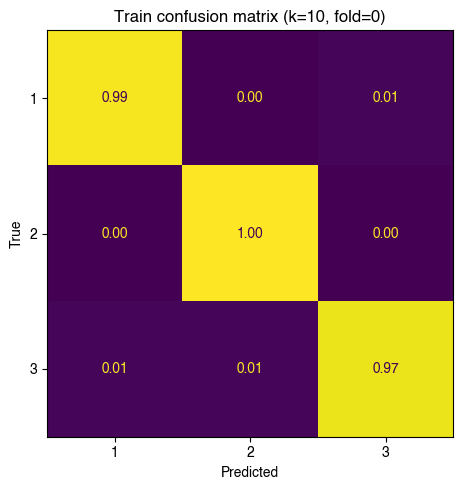

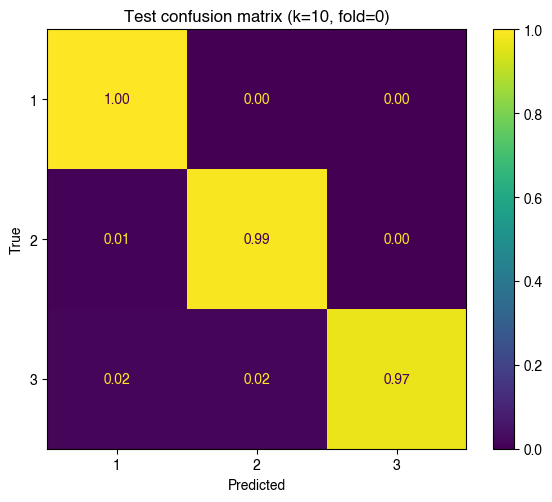

In [9]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ---------- helpers ----------

def find_config_index(params, target):
    """
    params: dict of arrays like in your file (uniformW, normalized, whitened, k, n_pot, t_training_delay, n_fold)
    target: dict with the exact values to match, e.g.
            dict(uniformW=True, normalized=True, whitened=False, k=256, n_pot=50, t_training_delay=0.0, n_fold=0)
    Returns the first matching index (int). Raises if none found.
    """
    keys = list(target.keys())
    mask = np.ones_like(params[keys[0]], dtype=bool)
    for k in keys:
        v = target[k]
        # be tolerant with float comparison
        if isinstance(v, float):
            mask &= np.isclose(params[k], v)
        else:
            mask &= (params[k] == v)
    idxs = np.flatnonzero(mask)
    if len(idxs) == 0:
        raise ValueError(f"No configuration matched: {target}")
    if len(idxs) > 1:
        print(f"Warning: {len(idxs)} configs matched; using the first (idx={idxs[0]}).")
    return int(idxs[0])

def get_preds_for_index(results, idx):
    """
    Supports two layouts:
      - Preferred: results['y_pred'][i], results['y_true'][i] for each config i
      - Fallback (your current code): single arrays results['y_pred'], results['y_true']
        (these correspond only to the *last* run)
    """
    if 'y_pred' in results and 'y_true' in results:
        y_pred = np.asarray(results['y_pred'], dtype=object)
        y_true = np.asarray(results['y_true'], dtype=object)
        y_pred = np.asarray(y_pred[idx]).astype(int)
        y_true = np.asarray(y_true[idx]).astype(int)
    else:
        # Fallback: use the only arrays available (likely from the last config)
        print("⚠️ Using results['y_pred'] / results['y_true'] (likely last run only).")
        y_pred = np.asarray(results['y_pred']).astype(int)
        y_true = np.asarray(results['y_true']).astype(int)
    return y_true, y_pred

def plot_confmat_pair(y_true_seq, y_pred_seq, n_train, class_labels=None,
                      normalize='true', title_suffix='', saveprefix=None):
    """
    Splits by n_train over the *sequence index* dimension and plots train/test CMs in separate figures.
    class_labels: array-like order of labels to show; if None, inferred from data.
    normalize: None|'true'|'pred'|'all' (sklearn semantics)
    saveprefix: if given, writes '<saveprefix>_train.pdf' and '<saveprefix>_test.pdf'
    """
    y_true_tr = y_true_seq[:n_train]
    y_pred_tr = y_pred_seq[:n_train]
    y_true_te = y_true_seq[n_train:]
    y_pred_te = y_pred_seq[n_train:]

    if class_labels is None:
        class_labels = np.unique(np.concatenate([y_true_tr, y_pred_tr, y_true_te, y_pred_te]))
        class_labels = class_labels[class_labels != 0]  # drop any zeros if present

    # Train
    cm_tr = confusion_matrix(y_true_tr, y_pred_tr, labels=class_labels,
                             normalize=(normalize if normalize else None))
    fig_tr, ax_tr = plt.subplots(figsize=(6, 5))
    ConfusionMatrixDisplay(cm_tr, display_labels=class_labels).plot(
        ax=ax_tr, values_format=('.2f' if normalize else 'd'), colorbar=False)
    ax_tr.set_title(f"Train confusion matrix {title_suffix}".strip())
    ax_tr.set_xlabel("Predicted")
    ax_tr.set_ylabel("True")
    fig_tr.tight_layout()
    if saveprefix:
        fig_tr.savefig(f"{saveprefix}_train.pdf", bbox_inches='tight')
        fig_tr.savefig(f"{saveprefix}_train.png",dpi=200, bbox_inches='tight')

    # Test
    cm_te = confusion_matrix(y_true_te, y_pred_te, labels=class_labels,
                             normalize=(normalize if normalize else None))
    fig_te, ax_te = plt.subplots(figsize=(6, 5))
    ConfusionMatrixDisplay(cm_te, display_labels=class_labels).plot(
        ax=ax_te, values_format=('.2f' if normalize else 'd'), colorbar=True)
    ax_te.set_title(f"Test confusion matrix {title_suffix}".strip())
    ax_te.set_xlabel("Predicted")
    ax_te.set_ylabel("True")
    fig_te.tight_layout()
    if saveprefix:
        fig_te.savefig(f"{saveprefix}_test.pdf", bbox_inches='tight')
        fig_te.savefig(f"{saveprefix}_test.png", dpi=200, bbox_inches='tight')


    return (fig_tr, ax_tr), (fig_te, ax_te)

# ---------- usage ----------

# Load your saved gridsearch
with open('data/gridsearch_full.pkl', 'rb') as f:
    data = pickle.load(f)

params = data['params']
results = data['results']

# Choose the configuration you want to visualize:
target_cfg = dict(
    uniformW=False,
    normalized=False,
    whitened=False,
    k=10,
    n_pot=6.,
    t_training_delay=5.0,  # float compare is tolerant via isclose
    n_fold=0,
)

idx = find_config_index(params, target_cfg)

# Pull predictions for that config (see note below if this warns)
y_true_seq, y_pred_seq = get_preds_for_index(results, idx)

# If you know the number of training sequences and class IDs, set them here:
# n_train must match your experiment; classes default to inferred if None.
n_train = 225  # <- use your actual n_train variable from the experiment scope
# Optionally, enforce a fixed class order (e.g., 1..n_out):
# class_labels = np.arange(1, n_out + 1)
class_labels = None

# Plot and save PDFs
plot_confmat_pair(
    y_true_seq=y_true_seq,
    y_pred_seq=y_pred_seq,
    n_train=n_train,
    class_labels=class_labels,
    normalize='true',
    title_suffix=f"(k={target_cfg['k']}, fold={target_cfg['n_fold']})",
    saveprefix='figs/confmat'  # -> saves figs/confmat_train.pdf and figs/confmat_test.pdf
)


In [19]:
n_hd = 10000
n_out = 3
k = 25
n_pot = 10
n_train = 225
w_teacher = 1.
t_training_delay = 0.

x_dense = sensor_data
n_dense = x_dense.shape[1]

labels = np.zeros_like(times_sec)
for i, t in enumerate(sequence_sec[:n_train]):
    try:
        flag = (times_sec > sequence_sec[i] + t_training_delay) & (times_sec < sequence_sec[i+1])
    except IndexError:
        flag = (times_sec > sequence_sec[i] + t_training_delay)
    labels[flag] = int(sequence[i][1])

idx_last_flag = np.where(labels != 0)[0][-1]

W_hd = np.random.binomial(n=1, p=0.05, size=(n_hd, n_dense))  #Test random sparse weights
x_hd = x_dense @ W_hd.T
z_hd = np.where(np.argsort(x_hd)<k, 1., 0)
W_out = np.zeros((n_out, n_hd))
W = np.zeros((n_out, n_hd))

z_out_train = np.zeros((z_hd.shape[0],  n_out))
for i, row in enumerate(z_hd[:idx_last_flag]):
    teacher = np.zeros((n_out,))
    if labels[i] != 0:
        teacher[int(labels[i]-1)] = w_teacher
    out = row @ W_out.T + teacher
    z_out_train[i] = out
    dW = (1./n_pot)*(np.atleast_2d(out).T @ np.atleast_2d(row))
    W += dW
    W_out = np.where(W>=1., 1./k, 0.)
    # if i%100 == 0:
    #     print(np.sum(W_out, axis=1))

z_out = np.zeros((z_hd.shape[0],  n_out))
for i, row in enumerate(z_hd):
    out = row @ W_out.T
    z_out[i] = out

z_wta = np.where(np.argsort(z_out, axis=1)<1, 1., 0)

z_pred = np.zeros_like(sequence_sec)
z_true = np.zeros_like(sequence_sec)
for i, t in enumerate(sequence_sec):
    try:
        flag = (times_sec > sequence_sec[i] + t_training_delay) & (times_sec < sequence_sec[i+1])
    except IndexError:
        flag = (times_sec > sequence_sec[i] + t_training_delay)
    z_pred[i] = np.argsort(np.sum(z_out[flag], axis=0))[-1] + 1
    z_true[i] = sequence[i][1]

train_acc = sklearn.metrics.accuracy_score(z_true[:n_train], z_pred[:n_train])
test_acc = sklearn.metrics.accuracy_score(z_true[n_train:], z_pred[n_train:])

print(f'k: {k}, n_pot: {n_pot}, t_training_delay: {t_training_delay}')
print(f'Train accuracy: {train_acc:.4f}, Test accuracy: {test_acc:.4f}')

k: 25, n_pot: 10, t_training_delay: 0.0
Train accuracy: 0.9911, Test accuracy: 0.8853


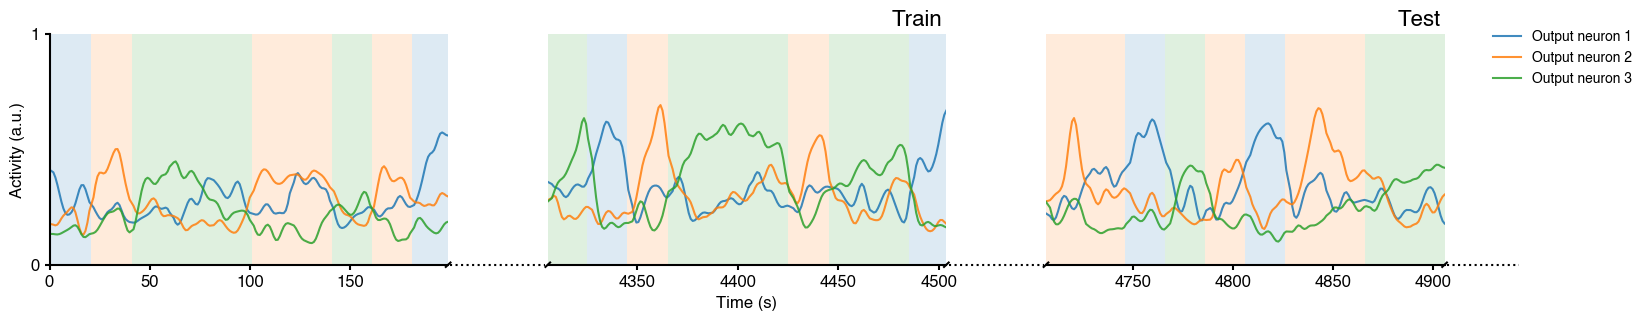

In [22]:
# ----- config -----
top_intervals_idx = [(0, 10), (215, 225)]   # left & middle (sequence-index windows)
j0, j1 = 235, 245                            # right "Test" (sequence-index)
max_len = 20
sigma = 2.
savepath = 'figs/hd_out'

# connector + slash styling
connector_color   = 'black'
connector_lw      = 1.5
connector_ls      = ':'      # dotted
slash_color       = 'black'
slash_lw          = 1.5
slash_len_fig     = 0.015
slash_angle_deg   = 80
slash_inset       = 0.003
# right slashes are NOT mirrored

# ----- style -----
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "legend.fontsize": 10
})
cm = plt.get_cmap('tab10')

# ----- per-sample block labels over full recording -----
colour = np.zeros_like(times_sec, dtype=int)
for i in range(len(sequence_sec)):
    t_start = sequence_sec[i]
    t_end = sequence_sec[i + 1] if i + 1 < len(sequence_sec) else np.inf
    mask = (times_sec >= t_start) & (times_sec < t_end)
    colour[mask] = int(sequence[i][1])

# ----- helpers -----
def seq_idx_window_to_sample_idx(a_idx, b_idx):
    a_idx = int(np.clip(a_idx, 0, len(sequence_sec) - 1))
    b_idx = int(np.clip(b_idx, 0, len(sequence_sec) - 1))
    t0_sec = sequence_sec[a_idx]
    t1_sec = sequence_sec[b_idx]
    t0 = int(np.abs(times_sec - t0_sec).argmin())
    t1 = int(np.abs(times_sec - t1_sec).argmin())
    if t1 <= t0:
        t1 = min(t0 + 1, len(times_sec))
    return t0, t1

def find_blocks(labels, max_len=20, ignore=0):
    labels = np.asarray(labels)
    n = len(labels)
    if n == 0: return []
    blocks, start, prev = [], 0, labels[0]
    for i in range(1, n + 1):
        cur = labels[i] if i < n else None
        if cur != prev:
            if prev != ignore:
                run_start, run_end, lab = start, i, int(prev)
                s = run_start
                while s < run_end:
                    e = min(s + max_len, run_end)
                    blocks.append((s, e, lab))  # [s, e) end-exclusive
                    s = e
            start, prev = i, cur
    return blocks

# Use midpoints between samples as span edges -> no visual gaps
def block_edges_from_indices(x, s, e):
    if s <= 0:
        L = x[0]
    else:
        L = 0.5 * (x[s-1] + x[s])
    if e >= len(x):
        R = x[-1]
    else:
        R = 0.5 * (x[e-1] + x[e])
    return L, R

# ----- figure (1x3) -----
fig, ax = plt.subplots(1, 3, figsize=(18, 3),
                       sharey=False,
                       gridspec_kw={'wspace': 0.25})
ax_l, ax_m, ax_r = ax[0], ax[1], ax[2]

# windows (sample indices)
t0_a, t1_a       = seq_idx_window_to_sample_idx(*top_intervals_idx[0])  # left
t0_b, t1_b       = seq_idx_window_to_sample_idx(*top_intervals_idx[1])  # middle
t0_test, t1_test = seq_idx_window_to_sample_idx(j0, j1)                 # right

# GLOBAL origin: first time from LEFT window
x0_ref = times_sec[t0_a]

def plot_interval_time_x(ah, t0, t1, title=None, hide_y=False):
    # time axis shifted by the SAME origin (x0_ref)
    x_raw = times_sec[t0:t1]
    x = x_raw - x0_ref

    labels_local = colour[t0:t1]
    blocks = find_blocks(labels_local, max_len=max_len)

    # traces vs time
    for i in range(z_out.shape[1]):
        smoothed = gaussian_filter1d(z_out[t0:t1, i], sigma=sigma)
        ah.plot(x, smoothed, label=f'Output neuron {i+1}', color=cm(i % cm.N), lw=1.5, alpha=0.85)

    # shaded blocks (midpoint edges => no gaps)
    for s, e, lab in blocks:
        if lab == 0:
            continue
        L, R = block_edges_from_indices(x, s, e)
        if R > L:
            ah.axvspan(L, R, facecolor=cm((lab-1) % cm.N), alpha=0.15, linewidth=0)

    # axes styling
    for side in ['top','right','left','bottom']:
        ah.spines[side].set_visible(side in ['left','bottom'])
        ah.spines[side].set_linewidth(1.5)
    ah.tick_params(axis='both', which='both', labelsize=12, width=1.5)
    ah.set_xlim(x[0], x[-1])
    ah.set_ylim(0., 1.)

    if not hide_y:
        ah.set_yticks([0, 1])
    else:
        ah.set_yticks([])
        ah.set_ylabel("")
        ah.spines['left'].set_visible(False)

    if title:
        ah.text(0.99, 1.06, title, transform=ah.transAxes,
                va="center", ha="right", fontsize=16)

# ----- plot panels (single row) -----
plot_interval_time_x(ax_l, t0_a,   t1_a,   title=None,   hide_y=False)  # left
plot_interval_time_x(ax_m, t0_b,   t1_b,   title="Train", hide_y=True)  # middle (hide y)
plot_interval_time_x(ax_r, t0_test,t1_test,title="Test",  hide_y=True) # right

# labels
ax_l.set_ylabel("Activity (a.u.)", fontsize=12)
ax_m.set_xlabel("Time (s)", fontsize=12)

# legend (from left), outside on the right
handles, labels = ax_l.get_legend_handles_labels()
fig.legend(handles, labels, frameon=False, loc="center left",
           bbox_to_anchor=(0.92, 0.80), ncol=1)

# ----- black dotted connectors + slashes (centered on axis; equal above/below) -----
from matplotlib.lines import Line2D

# helper: bottom-spine anchor at x∈[0,1] in *axes* coords → figure coords
def bottom_anchor_in_fig(ax, x_in_axes):
    pt_disp = ax.transAxes.transform((x_in_axes, 0.0))            # axes → display
    return fig.transFigure.inverted().transform(pt_disp)          # display → figure

# exact anchors at spine ends
pL_right = bottom_anchor_in_fig(ax_l, 1.0)
pM_left  = bottom_anchor_in_fig(ax_m, 0.0)
pM_right = bottom_anchor_in_fig(ax_m, 1.0)
pR_left  = bottom_anchor_in_fig(ax_r, 0.0)
pR_right = bottom_anchor_in_fig(ax_r, 1.0)

# geometry (identical everywhere)
theta  = np.deg2rad(slash_angle_deg)
dx_fig = slash_len_fig * np.cos(theta)  # total horizontal span of the slash
dy_fig = slash_len_fig * np.sin(theta)  # total vertical span of the slash
stub   = 0.04                           # dotted continuation length (figure coords)

def draw_centered_slash(anchor_xy):
    """Draw a slash centered on the anchor, spanning equally above/below the axis."""
    xA, yA = anchor_xy
    fig.add_artist(Line2D([xA - dx_fig/2, xA + dx_fig/2],
                          [yA - dy_fig/2, yA + dy_fig/2],
                          transform=fig.transFigure, lw=slash_lw,
                          color=slash_color, clip_on=False))

def draw_gap(p_left, p_right):
    """Two centered slashes at both anchors + dotted connector between their endpoints."""
    xL, yL = p_left
    xR, yR = p_right
    # slashes (centered, same orientation)
    draw_centered_slash((xL, yL))
    draw_centered_slash((xR, yR))
    # dotted connector from right end of left slash to left end of right slash (baseline = left y)
    fig.add_artist(Line2D([xL + dx_fig/2, xR - dx_fig/2], [yL, yL],
                          transform=fig.transFigure, linestyle=connector_ls,
                          lw=connector_lw, color=connector_color, clip_on=False))

# Left ↔ Middle
draw_gap(pL_right, pM_left)

# Middle ↔ Right
draw_gap(pM_right, pR_left)

# Right-edge: centered slash at the exact right end + dotted continuation
xE, yE = pR_right
draw_centered_slash((xE, yE))
fig.add_artist(Line2D([xE + dx_fig/2, xE + dx_fig/2 + stub], [yE, yE],
                      transform=fig.transFigure, linestyle=connector_ls,
                      lw=connector_lw, color=connector_color, clip_on=False))


plt.savefig(f'{savepath}.pdf', bbox_inches='tight')
plt.savefig(f'{savepath}.png', dpi=200, bbox_inches='tight')

plt.show()


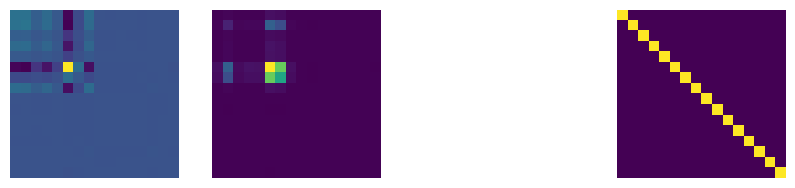

In [12]:
fig, ax = plt.subplots(1,4, figsize = (10,4))

ax[0].imshow(np.cov(sensor_data.T))
ax[1].imshow(np.cov(adap_whitening(sensor_data)[0].T))
ax[2].imshow(np.cov(adap_whitening_2(sensor_data)[0].T))
ax[3].imshow(np.cov(whiten(sensor_data).T))

for a in fig.axes:
    a.set_xticks([])
    a.set_yticks([])
    a.spines[:].set_visible(False)

In [13]:
adap_whitening_2(sensor_data)

(tensor([[ 5.1300e+02,  4.1770e+03,  3.7600e+02,  ...,  4.5000e+01,
           1.0000e+00, -3.0000e+00],
         [-8.1326e-11, -1.9414e-11, -1.0079e-10,  ..., -5.7007e-10,
          -2.1953e-08,  1.2640e-08],
         [        nan,         nan,         nan,  ...,         nan,
                  nan,         nan],
         ...,
         [        nan,         nan,         nan,  ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan,  ...,         nan,
                  nan,         nan],
         [        nan,         nan,         nan,  ...,         nan,
                  nan,         nan]]),
 tensor([[ 1.0234e+04,  4.9701e+03,  3.6526e+03,  ...,  9.1856e+03,
           8.6573e+03,  8.7188e+03],
         [ 4.6566e-09, -8.8476e-09, -2.9242e-08,  ...,  2.8729e-09,
           5.5501e-10, -1.8049e-09],
         [        nan,         nan,         nan,  ...,         nan,
                  nan,         nan],
         ...,
         [        nan,   